## Importing libraries & Reading files

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
from tqdm.notebook import tqdm
print("Libraries Imported.")

# path of fundamental data file
f_path     = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Fundamental Data.csv"

# path of closing prices file 
c_path     = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\All Close Prices.csv"

# path of daily closing prices of Indexes : Nifty50 / NiftyMidcap100 / BSE500  as Sheetnames
index_path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\CSV\Indexes Daily Closing.xlsx"


#reading files
fdf = pd.read_csv(f_path, encoding='windows-1252')
cdf = pd.read_csv(c_path, encoding='windows-1252')

print("file reading done.")
#fdf.drop(columns=['Unnamed: 0'],inplace=True)
#cdf.drop(columns=['Unnamed: 0'],inplace=True)

Libraries Imported.
file reading done.


# Input Variables
Enter your Input varibales here, in the given format

In [2]:
start_year = 2004                   # Format : YYYY
                                    # Run 2004 onwards to get apt results.

buy_date   = '2023-07-01'           # Format : YYYY-MM-DD
sell_date  = '2024-07-01'           # Format : YYYY-MM-DD

indicator  = "ROCE"                 # Format : "ROCE" or "ROE"

m = 0                               # Top companies Ranking from m
n = 30                              # Top companies Ranking till n
                                    # Get top m to n companies;    here get Top 0-30 companies

transaction_cost = 0.1              # Percentage of Transaction cost eg.input 1 if you want 1% ; here 0.1 => 0.1%
capital = 1000000                   # Capital in the beginning of the backtest

weightage = "equal"                 # "equal" / "marketcap" / "rank"

a = 500                             # Market Cap greater than equal to a =   500Cr   |   Put a = 0 if no Greater than condition
b = 20000                           # Market Cap smaller than equal to b = 20000Cr   |   Put b = np.inf if no Less than condition

positionsizing = "hold_stocks"      # Position Sizing methods
                                    # "sell_all_stocks"  : Sell all stocks every year and buy again if repeated in next year
                                    # "hold_stocks"      : Hold the stocks that repeat in next year

### Getting data from inputs
No output for this code, just some minor calculations.

In [3]:
initial_capital   = capital

buy_date = pd.to_datetime(buy_date)
sell_date = pd.to_datetime(sell_date)

buy_str  = f"-{buy_date.month}-{buy_date.day}"
sell_str = f"-{sell_date.month}-{sell_date.day}"

# Getting End Year date

if buy_date.month > 3:
    end_year = buy_date.year - 2
else :
    end_year = buy_date.year - 3
    
end_year

2021

----

## TRADE SHEET GENERATION CODE
Run this code to get the Trade Sheet

In [ ]:
#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 1




if positionsizing == "sell_all_stocks":
    


    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1['Market Cap']>=a) & (f1['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                                        # Buy Date

        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']


        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)

        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # Adding Selling Date
        f2['Sell Date'] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f3 = f2[m:n]

        #display(f3)

        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()

        #display(f3)

        # Claculating Quantity
        if weightage == "equal":
            f3['Qty'] = capital/((n-m)*f3['Close1'])
        elif weightage == "marketcap":
            f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
        elif weightage == "rank":
            new_weightage = f3.index[-1] - f3.index +1
            f3['Qty'] = (capital * (new_weightage/sum(f3.index))) / f3['Close1']



        # Defining a function to Roundown Quantity
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)




        # Rounddown Quantity
        f3['Qty'] = f3['Qty'].apply(Floor)
        
        
        # Qty Holding will be used to store the Quantity that we are holding since it was bought.
        f3['Qty Holding'] = f3['Qty']
        
        # Holding Amt will be used to store the Amount of Stock that we are holding since it was bought.
        f3['Holding Amt'] = f3['Qty']*f3['Close1']
        
        
        # Buying & Selling Value = Qty x Close Price
        f3['Buy Value'] = f3['Qty']*f3['Close1']
        f3['Sell Value'] = f3['Qty']*f3['Close2']

        f3['% Change'] = (f3['Close2'] / f3['Close1'] - 1)*100

        f3['Transaction Cost'] = (transaction_cost / 100)*(f3['Buy Value']+f3['Sell Value'])

        #print(f"{year} Starting Capital is {capital}")

        capital = f3['Sell Value'].sum() - f3['Transaction Cost'].sum()

        # print(f"{year} Ending Capital is {capital}")
        # print(year," Shape : ",f3.shape[0])
        change = change.append(f3)

    
    
    # Displaying our Trade Sheet
    display(change)
    
    # CAGR
    cagr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P1-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"
    
    #exporting the Trade Sheet
    change.to_excel(path_to,sheet_name="Trade Sheet")
    
    
    


    

#$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

#------------------------------------------------  POSITION SIZING  -----------------------------------------------------
#                                                    CONDITION 2  





elif positionsizing == "hold_stocks":


    # Blank Dataframe to store Yearly Tradesheet
    change = pd.DataFrame()
    f5 = pd.DataFrame()

    for year in tqdm(range(start_year, end_year+1)):

        print(f"{int(capital)} : Starting Capital for {year} ")
        f1 = fdf[fdf['Year']==year]

        # Fundamental Conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f1 = f1[f1.fillna(0)[condition] > 0]

        # Market Cap Condition
        f1 = f1[(f1.fillna(0)['Market Cap']>=a) & (f1.fillna(0)['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year

        # Indicator Conditions
        if indicator == "ROCE" :

            # Remove Banking stocks in ROCE
            f1 = f1[~f1['Name'].str.contains('Bank')]

            # ROCE Formula
            f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Total Debt"].fillna(0)))*100
            #f1[indicator] = (f1['Adj PBIT'].fillna(0) / (f1["Shareholder's Funds"].fillna(0) + f1["Long Term Borrowings"].fillna(0) + f1["Short Term Borrowings"].fillna(0)))*100

        elif indicator == "ROE" :

            # ROE Formula
            f1[indicator] = (f1['Adj PAT'].fillna(0) / f1["Shareholder's Funds"].fillna(0))*100


        # New dataframe to store calculations 
        f2 = f1[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f2['Buy Date'] = date(year+1,buy_date.month,buy_date.day)                                           # Buy Date



        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam  = cdf[cdf['Date'] == f'{year+1}{buy_str}']
        cnam2 = cdf[cdf['Date'] == f'{year+2}{sell_str}']


        # Reset Indexes
        f2.reset_index(drop=True,inplace=True)
        cnam.reset_index(drop=True,inplace=True)


        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam[['Name','Close']], how='left',on='Name').dropna()
        f2.rename(columns={'Close':'Close1'},inplace=True)

        f2['Sell Date' ] = date(year+2,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f2 = pd.merge(f2,cnam2[['Name','Close']], how='left',on='Name')
        f2.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes




        # SORTING VALUES BY INDICATOR
        f2 = f2.sort_values(by=[indicator], ascending=False)

        f2.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f3 = f2[m:n]

        #display(f3)


        # Filling companies with no Selling Prices with last present close and update the Selling Dates
        for i in range(f3.shape[0]):
            if f3.fillna(0)['Close2'].iloc[i] == 0 :
                f3['Close2'].iloc[i]    = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Close'].iloc[0]
                f3['Sell Date'].iloc[i] = cdf[(cdf['Name']==f3['Name'].iloc[i]) & (cdf['Date'] < f'{year+2}{sell_str}')].sort_values(by="Date", ascending=False)['Date'].iloc[0].date()





        # Defining a function for Roundown
        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)



        # Calculations for first year
        if year == start_year:

            f3['Prev Year'] = 0

            # Claculating Quantity
            if weightage == "equal":
                f3['Qty'] = capital/((f3.shape[0])*f3['Close1'])
            elif weightage == "marketcap":
                f3['Qty'] = (capital * (f3['Market Cap']/f3['Market Cap'].sum())) / f3['Close1']
            elif weightage == "rank":
                new_weightage = f3.index[-1] - f3.index +1
                f3['Qty'] = (capital * (new_weightage/sum(f3.index))) / f3['Close1']

            f3['Qty Holding'] = f3['Qty']    



        # Calculations for next years
        else:

            # Creating a column to store if the company is present in previous year.
            f3['Prev Year'] = f3['Name'].isin(f5['Name']).astype(int)

            n_prev = f3[f3['Prev Year'] == 0]                                          #Stocks not present in previous years
            y_prev = f3[f3['Prev Year'] == 1]                                          #Stocks present in previous years

            # Claculating Quantity for companies not present in previous year
            if weightage == "equal":
                n_prev['Qty'] = capital/((n_prev.shape[0])*n_prev['Close1'])
            elif weightage == "marketcap":
                n_prev['Qty'] = (capital * (n_prev['Market Cap']/n_prev['Market Cap'].sum())) / n_prev['Close1']
            elif weightage == "rank":
                new_weightage = a.index[-1] - a.index +1
                n_prev['Qty'] = (capital * (new_weightage/sum(f3.index))) / n_prev['Close1']


            n_prev['Qty Holding'] = n_prev['Qty']

            # Claculating Quantity for companies present in previous year
            y_prev[['Buy Date','Qty','Qty Holding']] = np.nan

            for k in range(y_prev.shape[0]):
                y_prev['Qty Holding'].iloc[k] = f5[f5['Name'] == y_prev['Name'].iloc[k]]['Qty Holding'].iloc[0]

            # Merging above 2 dataframes back to f3
            f3 = y_prev.append(n_prev)
            f3.sort_values(by=[indicator],ascending=False, inplace=True)

        f3['Qty'] = f3['Qty'].apply(Floor)
        f3['Qty Holding'] = f3['Qty Holding'].apply(Floor)
        f3['Buy Value'] = f3['Qty']*f3['Close1']








        #----------------------------------------------NEXT YEAR COMPANIES--------------------------------------------------


        # Finding Next years Companies to compare

        f4 = fdf[fdf['Year']==(year+1)]

        conditions = ["Shareholder's Funds", "PAT", "PBIT"]

        for condition in conditions:
            f4 = f4[f4.fillna(0)[condition] > 0]

        f4 = f4[(f4.fillna(0)['Market Cap']>=a) & (f4.fillna(0)['Market Cap']<=b)]

        cdf['Date'] = pd.to_datetime(cdf['Date'])
        cdf['Year'] = cdf['Date'].dt.year


        if indicator == "ROCE" :
            f4 = f4[~f4['Name'].str.contains('Bank')]
            f4[indicator] = (f4['Adj PBIT'].fillna(0) / (f4["Shareholder's Funds"].fillna(0) + f4["Total Debt"].fillna(0)))*100
        elif indicator == "ROE" :
            f4[indicator] = (f4['Adj PAT'].fillna(0) / f4["Shareholder's Funds"].fillna(0))*100

        f4 = f4[['Name','Market Cap',indicator]]                                                            # Name, Indicator
        f4['Buy Date'] = date(year+2,buy_date.month,buy_date.day)                                           # Buy Date

        # Dataframe of companies containing closings on 1st July of start year & next year
        cnam3  = cdf[cdf['Date'] == f'{year+2}{buy_str}']
        cnam4  = cdf[cdf['Date'] == f'{year+3}{sell_str}']

        # Reset Indexes
        f4.reset_index(drop=True,inplace=True)
        cnam3.reset_index(drop=True,inplace=True)

        # Adding Closing Prices of Start year (Buying Price) and dropping companies with no Closing prices 
        f4 = pd.merge(f4,cnam3[['Name','Close']], how='left',on='Name').dropna()
        f4.rename(columns={'Close':'Close1'},inplace=True)

        f4['Sell Date' ] = date(year+3,sell_date.month,sell_date.day)

        # Adding Closing Prices of Next year (Selling Price) and dropping companies with no Closing prices 
        f4 = pd.merge(f4,cnam4[['Name','Close']], how='left',on='Name')
        f4.rename(columns={'Close':'Close2'},inplace=True)                                     # Reset Indexes

        # SORTING VALUES BY INDICATOR
        f4 = f4.sort_values(by=[indicator], ascending=False)

        f4.reset_index(drop=True,inplace=True)                                                 # Reset Indexes

        # New Dataframe to store Top n Companies and Find Quantity
        f4 = f4[m:n]

    #------------------------------------------------------------------------------------------------------------------------
    



        # Creating a column to store if the company is present in next year.
        f3['Next Year'] = f3['Name'].isin(f4['Name'].tolist()).astype(int)
        n_next = f3[f3['Next Year']==0]
        y_next = f3[f3['Next Year']==1]

        # Calculating Sell Value and Sell Date differently for above 2 dataframes
        n_next['Sell Value'] = n_next['Qty Holding']*n_next['Close2']
        y_next[['Sell Date','Sell Value']] = np.nan


        f3 = y_next.append(n_next)
        f3.sort_values(by=[indicator],ascending=False, inplace=True)


        f3['Transaction Cost'] = (transaction_cost / 100)*(f3.fillna(0)['Buy Value']+f3.fillna(0)['Sell Value'])

        f3['% Change'] = (f3['Close2']/f3['Close1']-1)*100 

        f5 = f3.copy()

        portfolio_value = ((f3['Qty Holding']*f3['Close2']) - f3['Transaction Cost']).sum()


        # Changing Capital for next year to Ending capital of this year 
        capital = (capital - f3.fillna(0)['Buy Value'].sum()) + f3.fillna(0)['Sell Value'].sum() - f3['Transaction Cost'].sum()
        print(int(capital),": Ending Capital")


        # Appending every year's Trade file to a Dataframe "change"
        change = change.append(f3)


    #------------------------------------------GETTING TRADESHEET FROM ABOVE DATAFRAME-----------------------------------------




    change2 = change.copy()
    s = pd.DataFrame(columns=change2.columns)
    change2.reset_index(drop=True, inplace=True)
    comp_list = []
    for i in range(change2.shape[0]):
        if change2['Name'].iloc[i] not in comp_list:

            t = change2[change2['Name']==change2['Name'].iloc[i]]
            t = t[(t.fillna(0)['Buy Date']!=0) | (t.fillna(0)['Sell Date']!=0)]

            comp_list.append(change2['Name'].iloc[i])
            #display(t)

            for g in range(t.shape[0]):

                if t.fillna(0)['Buy Date'].iloc[g] !=0 and t.fillna(0)['Sell Date'].iloc[g] !=0 :
                    s = s.append(t.iloc[g])
                elif t.fillna(0)['Buy Date'].iloc[g] ==0 and t.fillna(0)['Sell Date'].iloc[g] ==0 :
                    continue
                elif t.fillna(0)['Buy Date'].iloc[g] !=0 and t.fillna(0)['Sell Date'].iloc[g] ==0 :
                    s = s.append(t.iloc[g])

                elif t.fillna(0)['Buy Date'].iloc[g] ==0 and t.fillna(0)['Sell Date'].iloc[g] !=0:

                    s['Sell Date'].iloc[-1]  = t['Sell Date'].iloc[g]
                    s['Close2'].iloc[-1]     = t['Close2'].iloc[g]
                    s['Sell Value'].iloc[-1] = t['Sell Value'].iloc[g]
        else:
            continue

    s['% Change'] = (s['Close2']/s['Close1']-1)*100      

    s = s.sort_values(by=['Buy Date','ROCE'], ascending=[True,False])

    TradeSheet = s[['Name','Market Cap','ROCE','Buy Date','Close1','Sell Date','Close2','Qty','Buy Value','Sell Value','Qty Holding','% Change','Transaction Cost']]
    TradeSheet.reset_index(drop=True,inplace=True)    

    cagr        = ((portfolio_value/initial_capital)**(1/(buy_date.year-start_year))-1)*100


    display(change)
    display(TradeSheet)
    print(cagr)
    
    
    
    # Unique path according to the input variables to store the Trade File, same will be used to store the Trade Reports later.
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P2-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-Reports.xlsx"

    
    # Exporting files
    change.to_excel(path_to,sheet_name="Trade Report Sheet")
    TradeSheet.to_excel(fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\P2-{start_year}-{str(end_year)[-2:]}-{indicator}-Backtest-{initial_capital}-{buy_date.date()}-{sell_date.date()}-{positionsizing}-{m}-{n}-{transaction_cost}-{a} {b}-{weightage}-TradeSheet.xlsx")

----------

## REPORTS GENERATION CODE
Run this code to get the Trade Reports  
  
**You'll get the following as outputs:**
* *Top Winners*
* *Top Losers*
* *Daily Portfolio Value from start date to end*
* *Portfolio Graph*
* *Drawdown Graph*
* *CAGR, Trading Edge, MDD & CAR/MDD*


TOP WINNERS


,Name,Buy Date,% Change
0,IIFL Finance Ltd.,2006-07-01,556.787851
1,Alkyl Amines Chemicals Ltd.,2020-07-01,327.409117
2,Deepak Nitrite Ltd.,2020-07-01,293.180157
3,Tanfac Industries Ltd.,2022-07-01,241.671931
4,TTK Prestige Ltd.,2010-07-01,240.379754
5,Symphony Ltd.,2013-07-01,231.245006
6,Indiamart Intermesh Ltd.,2020-07-01,223.082839
7,Sonata Software Ltd.,2020-07-01,216.624738
8,LS Industries Ltd.,2012-07-01,202.103250
9,Coforge Ltd.,2006-07-01,193.879875



TOP LOSERS


,Name,Buy Date,% Change
0,Capri Global Capital Ltd.,2010-07-01,-88.857609
1,Spectacle Ventures Ltd.,2010-07-01,-87.167806
2,Securekloud Technologies Ltd.,2018-07-01,-82.825089
3,Stampede Capital Ltd.,2016-07-01,-80.411499
4,Suumaya Industries Ltd.,2021-07-01,-78.824268
5,EKI Energy Services Ltd.,2022-07-01,-75.896348
6,Vakrangee Ltd.,2017-07-01,-68.964717
7,Coforge Ltd.,2007-07-01,-66.074196
8,MIC Electronics Ltd.,2008-07-01,-65.945437
9,Paul Merchants Ltd.,2018-07-01,-65.376787


  0%|          | 0/18 [00:00<?, ?it/s]


Daily Portfolio Value


,Date,PV
0,2023-06-30 00:00:00,9754568.29
1,2023-06-29 00:00:00,9754568.29
2,2023-06-28 00:00:00,9754568.29
3,2023-06-27 00:00:00,9754568.29
4,2023-06-26 00:00:00,9754568.29
...,...,...
360,2005-07-05 00:00:00,1015089.599885
361,2005-07-04 00:00:00,1011501.907045
362,2005-07-03 00:00:00,998395.919277
363,2005-07-02 00:00:00,998395.919277


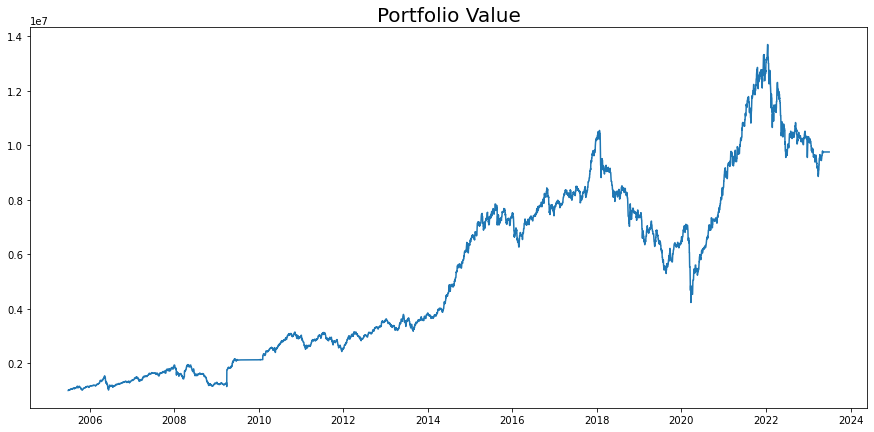

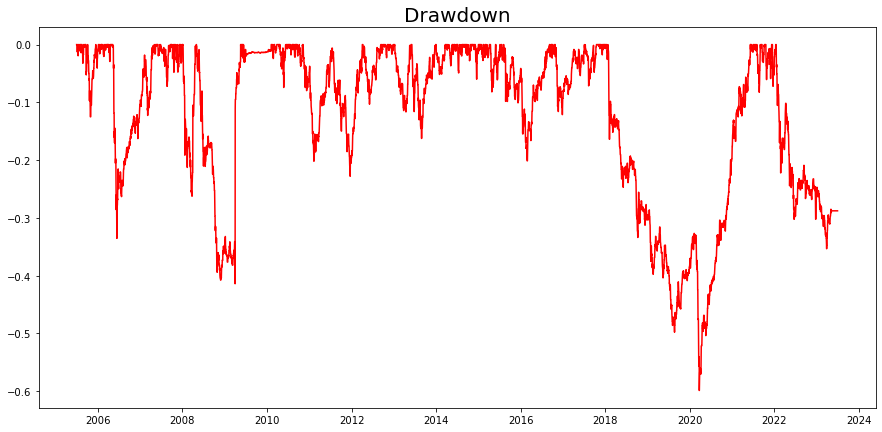

,CAGR,Trading Edge,MDD,CAR/MDD
0,12.726394,19.279738,-59.891143,0.212492


In [5]:
# TOP n Winners & Losers

winners = change[change['% Change']>0].sort_values(by="% Change", ascending=False)[['Name','Buy Date','% Change']]
losers  = change[change['% Change']<0].sort_values(by="% Change", ascending=True )[['Name','Buy Date','% Change']]
winners.reset_index(drop=True, inplace=True)
losers.reset_index(drop=True, inplace=True)

# Count of Winners & Losers
winners_counts = change[change['% Change']>0].shape[0] / change.shape[0]
losers_counts  = change[change['% Change']<0].shape[0] / change.shape[0]

# Average Win/Loss percentage
avg_win  = change[change['% Change']>0]['% Change'].mean()
avg_loss = change[change['% Change']<0]['% Change'].mean()


# Display Top 10 Winners & Losers
print("\nTOP WINNERS")
display(winners[:10])

print("\nTOP LOSERS")
display(losers[:10])




# Finding Daily Portfolio Value

k = 0

# Dataframe to append all year's Daily Portfolio Values
combined_PV = pd.DataFrame(columns=['Date','PV'])

for year in tqdm(range(start_year,end_year+1)):
    
    
    # Dataframe to add every stocks's Daily close price so as to get Daily Total Portfolio Value
    multipv = pd.DataFrame(columns=['Date','PV'])
    multipv['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
    multipv['PV'].fillna(0,inplace=True)
    
    
    
    #loop to go into each company from our trade sheet      //     i represents rows of the Trade Sheet.
    for i in range(k,(n-m)+k):
        
        # varibale to store close prices from start date to end date of a company
        pv1 = cdf[(cdf['Name']==change['Name'].iloc[i]) & (cdf['Date'] >= f'{year+1}{buy_str}') & (cdf['Date'] < f'{year+2}{sell_str}')]

        pv1 = pv1[['Name','Date','Close']]
        pv1.reset_index(drop=True, inplace = True)

        
        
        # filling all the missing dates in the above dataframe 
        all_dates = pd.DataFrame(columns=['Name','Date','Close'])
        all_dates['Date'] = pd.date_range(date(year+1,buy_date.month,buy_date.day) ,date(year+2,sell_date.month,sell_date.day)-datetime.timedelta(1)).sort_values(ascending=False)
        
        for j in range(all_dates.shape[0]):
            if all_dates['Date'].iloc[j] not in pv1['Date'].tolist():
                pv1 = pv1.append(all_dates.iloc[j])
        
        
        pv1.sort_values(by='Date', ascending=False, inplace=True) 
        pv1.reset_index(drop=True, inplace = True)
        
        
        # filling close prices as previous prices or next prices for newly added dates
        pv1 = pv1[['Name','Date','Close']].bfill().ffill()
        pv1.reset_index(drop=True, inplace = True)
        
        
        # Calculating Contract Value by Multiplying Close prices by Quantity of that company
        pv1['PV'] = pv1['Close']*change['Qty Holding'].iloc[i]
        pv1['Date'] = pd.to_datetime(pv1['Date'])

        # Adding the above company's Contarct Value to the previous company's Contract Value
        multipv['PV'] = np.where(multipv['Date'] == pv1['Date'], multipv['PV']+pv1['PV'], np.nan)
    
    
    # appending the above year's Daily Porfolio Value in a New Dataframe
    combined_PV = multipv.append(combined_PV)
    
    k += (n-m)

print("\nDaily Portfolio Value")
display(combined_PV)

print()


# Calculating Drawdown of our Portfolio
combined_PV = combined_PV.sort_values(by='Date', ascending=True)
combined_PV['MDD'] = (combined_PV['PV']/combined_PV['PV'].rolling(len(combined_PV),1).max())-1
combined_PV = combined_PV.sort_values(by='Date',ascending=False)
combined_PV.reset_index(drop=True,inplace=True)


# Plotting Daily Portfolio Value
plt.figure(figsize=(15,7))
plt.plot(combined_PV["Date"],combined_PV["PV"])
plt.title("Portfolio Value", fontsize=20)
plt.show()

print()

# Plotting Daily Drawdown of our Portfolio
plt.figure(figsize=(15,7))
plt.plot(combined_PV["Date"],combined_PV["MDD"],color = 'red')
plt.title("Drawdown", fontsize=20)
plt.show()


# Ratios

tradingedge = winners_counts*avg_win + losers_counts*avg_loss

cagr        = ((capital/initial_capital)**(1/(buy_date.year-start_year))-1)*100

mdd         = min(combined_PV['MDD'])*100

# Dataframe to store the above Ratios
calc = pd.DataFrame({"CAGR":[cagr],  "Trading Edge":[tradingedge], "MDD":[mdd], "CAR/MDD":[-cagr/mdd]})

display(calc)

___________

## Monthly Table
You'll get a matrix of Years and Months as output, which will have the monthly change of our Portfolio Value.

In [6]:
# Monthly Table

monthlydf = combined_PV.copy()

# Extracting Month & Year from the Date column
monthlydf['Date']  = pd.to_datetime(monthlydf['Date'])
monthlydf['Month'] = monthlydf['Date'].dt.month
monthlydf['Year']  = monthlydf['Date'].dt.year

# keeping only the last day of the month for each year
monthlydf = monthlydf.drop_duplicates(subset=['Month','Year'])[['Month','Year','PV']].reset_index(drop=True)
monthlydf['% Change'] = np.nan

# keeping only the last day of the year for each year
yearlydf = monthlydf.drop_duplicates(subset=['Year']).sort_values(by='Year',ascending=False).reset_index(drop=True)
yearlydf['% Change'] = np.nan

# Percentage change every month
for i in range(monthlydf.shape[0]):
    try:
        monthlydf['% Change'].iloc[i] = (monthlydf['PV'].iloc[i]/monthlydf['PV'].iloc[i+1] - 1)*100
    except:
        continue

        
# Percentage change every year
for i in range(yearlydf.shape[0]):
    try:
        y = monthlydf[monthlydf['Year']==yearlydf['Year'].iloc[i]]
        yearlydf['% Change'].iloc[i] = (y['PV'].iloc[0]/y['PV'].iloc[-1] - 1)*100
        
        #yearlydf['% Change'].iloc[i] = (yearlydf['PV'].iloc[i]/yearlydf['PV'].iloc[i+1] - 1)*100
        
    except:
        continue
        
        
# storing the unique years as a list
monthly_years = monthlydf['Year'].unique().tolist()
monthly_years = ['Months']+monthly_years

# New Dataframe to store our Monthly Table
monthly_matrix = pd.DataFrame(columns=monthly_years)
monthly_matrix['Months'] = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec']


for i in range(monthly_matrix.shape[0]):
    for j in monthlydf['Year'].unique().tolist():
        try:
            monthly_matrix[j].iloc[i] = monthlydf[(monthlydf['Month']==i+1) & (monthlydf['Year']==j)]['% Change'].iloc[0]
        except:
            continue
            
# The above Matrix has Months as rows & Years as columns
            
# Transposing the Matrix            
monthly_matrix = monthly_matrix.T
monthly_matrix.columns = monthly_matrix.iloc[0]
monthly_matrix.drop('Months', inplace=True)

monthly_matrix['Months']=monthly_matrix.index
monthly_matrix['Total'] = np.nan

# Adding yearly returns to the matrix
for i in range(monthly_matrix.shape[0]):
    monthly_matrix['Total'].iloc[i] = yearlydf[yearlydf['Year']==monthly_matrix['Months'].iloc[i]]['% Change'].iloc[0]

    
monthly_matrix.columns.name = ''
monthly_matrix.reset_index(drop=True, inplace=True)
monthly_matrix = monthly_matrix[['Months','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sept','Oct','Nov','Dec','Total']]

# Adding Last row to store average returns of each month
monthly_matrix.loc['Average'] = monthly_matrix.mean()





display(monthly_matrix)




,Months,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sept,Oct,Nov,Dec,Total
0,2023,-2.342725,-5.32209,-2.978082,5.743891,1.328536,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.574966
1,2022,-3.886218,-9.755819,0.381435,2.38038,-8.611492,-9.085745,7.827948,0.099939,-2.1005,-0.408632,2.503765,-2.63573,-19.068113
2,2021,2.651532,6.456067,1.832743,3.953484,3.519863,4.962768,8.340612,-0.047804,3.030782,2.823065,0.994279,4.753283,48.614591
3,2020,6.489248,-6.071069,-29.061398,21.071607,-2.091026,10.519142,4.659677,8.358328,5.632928,-0.237843,7.355794,9.952314,23.146199
4,2019,-8.416266,-3.518465,5.160178,-2.423253,2.031074,-5.633091,-14.037632,-0.272355,6.337497,7.829749,0.866058,1.3304,-4.230371
5,2018,-4.406816,-7.252399,-0.638001,-0.679215,-7.930102,-0.788837,2.766605,-0.596718,-11.701353,1.157726,0.40118,-1.230403,-24.349937
6,2017,3.092895,-0.691214,6.278532,-1.366756,-2.295597,3.868663,-0.311917,-1.014794,-0.85863,9.65096,9.457578,5.045642,30.304668
7,2016,-8.174429,-8.759845,7.219414,5.071075,3.056777,1.273694,3.241486,2.368404,1.731275,5.109787,-6.453838,-2.020944,11.120165
8,2015,2.961221,2.372279,5.205528,-2.12232,8.070407,-0.957839,2.530197,-2.380261,-1.427333,2.451221,-2.979547,2.715914,13.656847
9,2014,-4.447868,2.88907,5.336024,-0.85866,6.633267,9.961671,4.861296,5.907461,9.982082,2.3997,6.455603,4.095988,74.622383


---------

## Comparison with Indexes ⬇
Comparing the returns of our Portfolio with :
* *Nifty 50*
* *Nifty Midcap 100*
* *BSE500*

,Date,Nifty50,NiftyMidcap100,BSE500,QGF
0,2023-05-15,18380.70,32584.35,24705.79,9754568.29
1,2023-05-14,18314.80,32468.45,24622.46,9754568.29
2,2023-05-13,18314.80,32468.45,24622.46,9754568.29
3,2023-05-12,18314.80,32468.45,24622.46,9754568.29
4,2023-05-11,18297.00,32601.30,24631.35,9754568.29
...,...,...,...,...,...
6523,2005-07-05,2210.75,3396.35,7000.55,1015089.599885
6524,2005-07-04,2230.65,3396.35,7000.55,1011501.907045
6525,2005-07-03,2211.90,3396.35,7000.55,998395.919277
6526,2005-07-02,2211.90,3396.35,7000.55,998395.919277


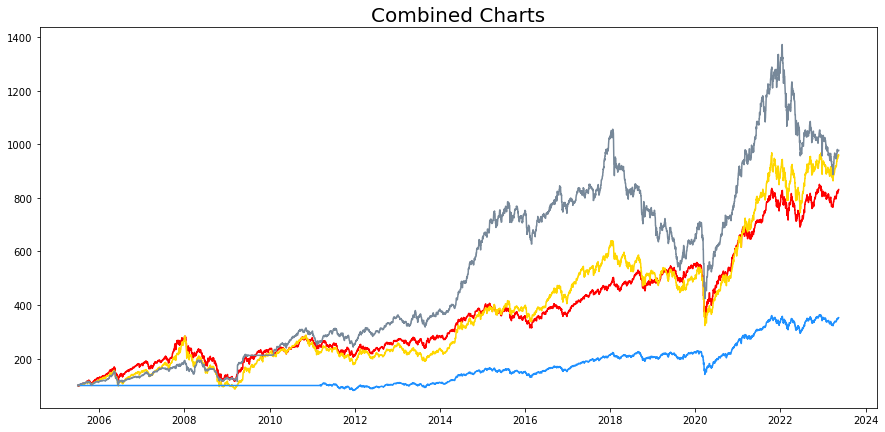

Nifty50        : RED 
NiftyMidcap100 : YELLOW 
BSE500         : BLUE 
QGF            : GREY


,Index,CAGR
0,Nifty50,11.789192
1,NiftyMidcap100,12.637767
2,BSE500,6.862310
3,QGF,12.745775


,Date,Nifty50,NiftyMidcap100,BSE500,QGF
0,2023-05-15,830.991455,959.393172,352.912128,977.024054
1,2023-05-14,828.012116,955.980685,351.721793,977.024054
2,2023-05-13,828.012116,955.980685,351.721793,977.024054
3,2023-05-12,828.012116,955.980685,351.721793,977.024054
4,2023-05-11,827.207378,959.892237,351.848783,977.024054
...,...,...,...,...,...
6523,2005-07-05,99.948008,100.000000,100.000000,101.67205
6524,2005-07-04,100.847688,100.000000,100.000000,101.312704
6525,2005-07-03,100.000000,100.000000,100.000000,100.0
6526,2005-07-02,100.000000,100.000000,100.000000,100.0


In [7]:
# Comparison with Indexes


indexes = ['Nifty50','NiftyMidcap100','BSE500']

comparisons = pd.DataFrame({'Index':['Nifty50', 'NiftyMidcap100', 'BSE500','QGF']})
comparisons['CAGR'] = np.nan

combined_ind = pd.DataFrame()
# combined_ind['Date'] = pd.date_range(date(start_year,buy_date.month,buy_date.day) ,date(buy_date.year,buy_date.month,buy_date.day)-datetime.timedelta(1)).sort_values(ascending=False)


for index in indexes:
    idf  = pd.read_excel(index_path, sheet_name=index)
    idf['Date'] = pd.to_datetime(idf['Date'])
    
    idf2 = idf[(idf['Date'] >= str(start_year+1)+buy_str) & (idf['Date'] <= str((date(buy_date.year,buy_date.month,buy_date.day)-datetime.timedelta(1))))]
    idf2['Date'] = pd.to_datetime(idf2['Date'])
    #display(idf2)
    
    combined_ind['Date'] = idf2['Date']
    combined_ind[index] = idf2['Close']
    
    for i in range(comparisons.shape[0]):
        if comparisons['Index'].iloc[i] == index:
            comparisons['CAGR'].iloc[i] = ((idf2['Close'].iloc[0]/idf2[idf2['Close']!=0]['Close'].iloc[-1])**(1/(buy_date.year-start_year))-1)*100
            
        elif comparisons['Index'].iloc[i] == 'QGF':
            comparisons['CAGR'].iloc[i] = ((combined_PV['PV'].iloc[0]/combined_PV['PV'].iloc[-1])**(1/(buy_date.year-start_year))-1)*100
    
pv = combined_PV[(combined_PV['Date'] >= combined_ind['Date'].iloc[-1]) & (combined_PV['Date'] <= combined_ind['Date'].iloc[0])]
#display(pv)

pv.reset_index(drop=True,inplace=True)

combined_ind['QGF'] = pv['PV']

display(combined_ind)

for column in combined_ind.columns:
    if column == 'Date':
        continue
    else:
        combined_ind[column] = (combined_ind[column]  / combined_ind[column].iloc[-1])*100


plt.figure(figsize=(15,7))
plt.plot(combined_ind["Date"],combined_ind["Nifty50"], color = "red")
plt.plot(combined_ind["Date"],combined_ind["NiftyMidcap100"], color = "gold")
plt.plot(combined_ind["Date"],combined_ind["BSE500"],"dodgerblue")
plt.plot(combined_ind['Date'], combined_ind['QGF'],color="lightslategrey")
plt.title("Combined Charts", fontsize=20)
plt.show()

print("Nifty50        : RED \nNiftyMidcap100 : YELLOW \nBSE500         : BLUE \nQGF            : GREY")
    
    
display(comparisons)

display(combined_ind)


---------

## Save the Output files
Run this Code to save all the Output Reports & files you get.

In [9]:
with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
    combined_PV.to_excel(writer,sheet_name="Daily Portfolio Value",index=False)
    winners.to_excel(writer,sheet_name="Winners",index=False)
    losers.to_excel(writer,sheet_name="Losers",index=False)
    calc.to_excel(writer,sheet_name="Calculations",index=False)
    monthly_matrix.to_excel(writer,sheet_name="Monthly Table",index=False)
    combined_ind.to_excel(writer,sheet_name="Daily Index Prices",index=False)
    comparisons.to_excel(writer,sheet_name="Index Comparisons",index=False)

___________

## Output Variable names
* change : Tradelist
* combined_PV : Daily Portfolio Value
* winners : All Winners in descending
* losers : All Losers in ascending
* cagr : CAGR
* tradingedge : Trading Edge
* mdd : Max Drawdown
* monthly_matrix : Monthly Table
* comparisons : QGF vs Indexes change
* combined_ind : Daily Index Prices for given range

___________